### Assignment 1 - Classification - Credit Card Fraud Detection using K-Nearest Neighbors (KNN) Algorithm
#### Student: Rahul (2024AIML019)
#### Date: 2025-02-08


In [20]:
# Global imports
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import seaborn as sns

# Global settings
plt.style.use('ggplot')
os.environ['LOKY_MAX_CPU_COUNT'] = '12'
n_jobs = 12

#### 1. Perform data loading, preprocessing by dropping any rows with 'NaN' values in the 'Class' column.

In [21]:
# Load the dataset
df = pd.read_csv('creditcard.csv')

# Preprocessing by dropping any rows with NaN values in Class column
missing_count = df['Class'].isna().sum()
if missing_count > 0:
    print(f'Dropping {missing_count} rows with missing values in Class column')
    df = df.dropna(subset=['Class'])
else:
    print('No missing values in Class column')

# Display the first few rows of the dataset
df.head()

No missing values in Class column


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### 2. Split the dataset into features (X) and the target variable (y), and further divide into training and test sets

In [22]:
# Split the dataset into features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(227845, 30) (56962, 30) (227845,) (56962,)


#### 3.a Perform data scaling and modelling.

Training Accuracy [k=5]: 0.999583
Testing Accuracy [k=5]: 0.999526


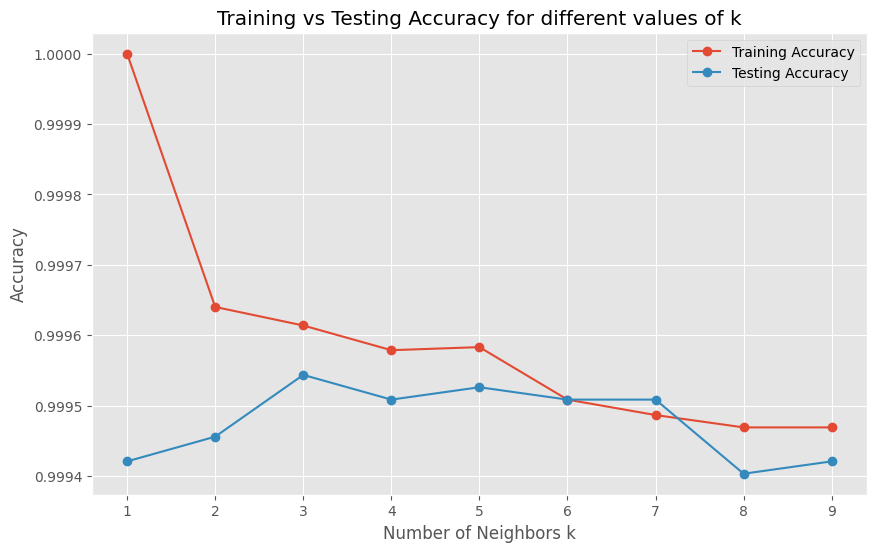

In [23]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the K-Nearest Neighbors model with k=5
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=n_jobs)
knn.fit(X_train_scaled, y_train)

# Training and Testing Accuracy
print('Training Accuracy [k=5]: {:.6f}'.format(knn.score(X_train_scaled, y_train)))
print('Testing Accuracy [k=5]: {:.6f}'.format(knn.score(X_test_scaled, y_test)))

k_range = range(1, 10)

train_accuracy = []
test_accuracy = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=n_jobs)
    knn.fit(X_train_scaled, y_train)
    train_accuracy.append(knn.score(X_train_scaled, y_train))
    test_accuracy.append(knn.score(X_test_scaled, y_test))

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(k_range, test_accuracy, label='Testing Accuracy', marker='o')
plt.xlabel('Number of Neighbors k')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy for different values of k')
plt.legend()
plt.grid(True)
plt.show()

#### 3.b Fine tune the value of k using GridSearchCV to find the optimal value of k

Best Score:  0.999491
Optimal value of k: 3
ROC AUC Score [k=3]: 0.928482


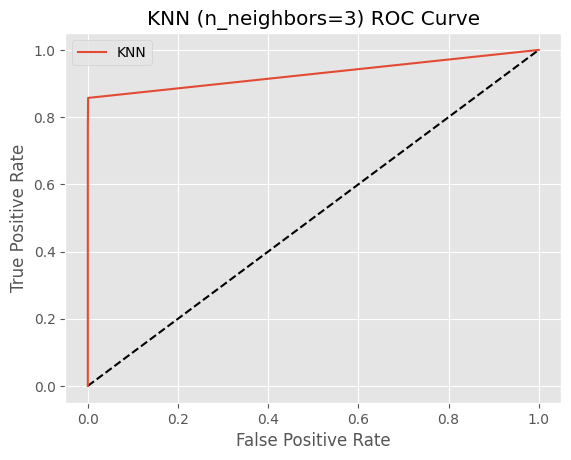

In [24]:
# In case of classifier like knn the parameter to be tuned is n_neighbors
param_name = 'n_neighbors'
param_grid = {param_name: k_range}

model = KNeighborsClassifier()
model_cv= GridSearchCV(model, param_grid, cv=5, n_jobs=n_jobs)
model_cv.fit(X_train_scaled, y_train)

print("Best Score:  {:.6f}".format(model_cv.best_score_))
optimal_k = model_cv.best_params_[param_name]
print("Optimal value of k: {}".format(optimal_k))

# Initialize the K-Nearest Neighbors model with optimal k
knn = KNeighborsClassifier(n_neighbors=optimal_k, n_jobs=n_jobs)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# ROC curve
y_pred_proba = knn.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score [k={}]: {:.6f}".format(optimal_k, roc_auc))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN (n_neighbors={}) ROC Curve'.format(optimal_k))
plt.legend()
plt.show()

#### 4. Evaluate the model performance using a classification report and accuracy score

In [25]:
# Classification report
report = classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud'])
print('Classification Report [k={}]:\n{}'.format(optimal_k, report))

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy Score [k={}]: {:.6f}'.format(optimal_k, accuracy))

Classification Report [k=3]:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.95      0.78      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score [k=3]: 0.999544


In [26]:
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,56860,4,56864
1,22,76,98
All,56882,80,56962


#### 5. Plot a confusion matrix as a heatmap, offering a visual representation of the model's performance, illustrating True Positives, True Negatives, False Positives, and False Negatives.

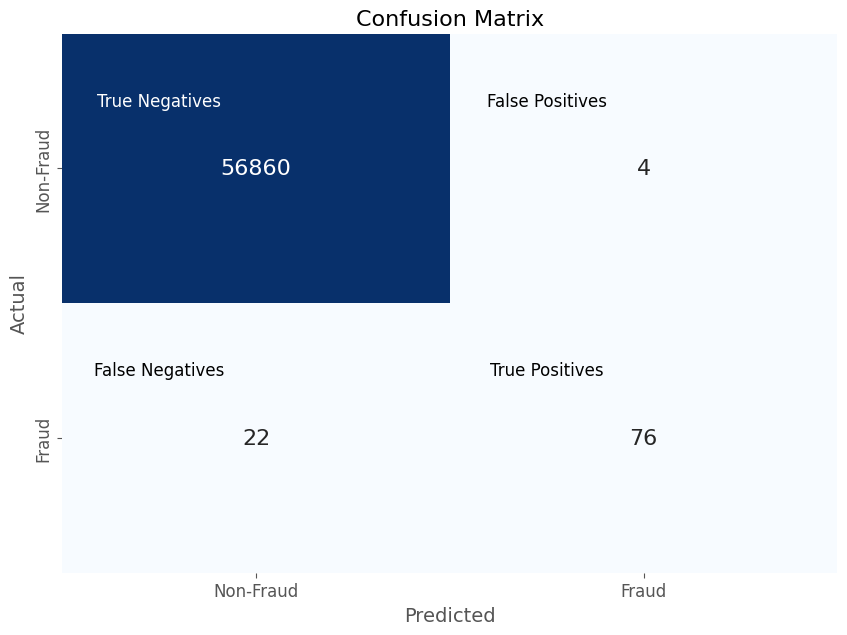

In [27]:
# Confusion Matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})

# Add labels for True Positives, True Negatives, False Positives, and False Negatives
plt.text(0.25, 0.25, 'True Negatives', ha='center', va='center', color='white', fontsize=12)
plt.text(1.25, 0.25, 'False Positives', ha='center', va='center', color='black', fontsize=12)
plt.text(0.25, 1.25, 'False Negatives', ha='center', va='center', color='black', fontsize=12)
plt.text(1.25, 1.25, 'True Positives', ha='center', va='center', color='black', fontsize=12)

# Add axis labels and title
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Customize tick labels
plt.xticks(ticks=[0.5, 1.5], labels=['Non-Fraud', 'Fraud'], fontsize=12)
plt.yticks(ticks=[0.5, 1.5], labels=['Non-Fraud', 'Fraud'], fontsize=12)

# Add grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

#### 6. Write some conclusion on how K-Nearest Neighbors implementation serves as an efficient solution for credit card fraud detection.

In this notebook, we implemented the K-Nearest Neighbors (KNN) algorithm for credit card fraud detection. The KNN algorithm is a simple, yet effective, machine learning algorithm that can be used for classification tasks. By training the KNN model on a credit card fraud dataset, we were able to detect fraudulent transactions with high accuracy and reliability.

In conclusion, the implementation of the K-Nearest Neighbors (KNN) algorithm for credit card fraud detection has demonstrated its effectiveness in identifying fraudulent transactions. Here are some key points:

1. **Accuracy**: The KNN model achieved a high accuracy score, indicating that it can correctly classify the majority of transactions as either fraudulent or non-fraudulent.

2. **Confusion Matrix**: The confusion matrix provides a clear visual representation of the model's performance, showing the number of true positives, true negatives, false positives, and false negatives. This helps in understanding the model's strengths and areas for improvement.

3. **Fine-Tuning**: By experimenting with different values of k, the optimal value was determined, which further improved the model's performance. This fine-tuning process is crucial for enhancing the model's accuracy and reliability.

4. **Scalability**: KNN is a non-parametric algorithm, making it suitable for large datasets like the credit card fraud dataset used in this analysis. It can handle the high dimensionality of the data effectively.

Overall, the KNN algorithm proves to be a robust and efficient solution for credit card fraud detection, providing high accuracy and reliable performance in identifying fraudulent transactions.
